<a href="https://colab.research.google.com/github/satoruk-icepp/mlhep2019_2_phase/blob/master/Bayesian_lhcb_calo_gan_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py -nc
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py -nc
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/score.py -nc
! wget https://github.com/satoruk-icepp/mlhep2019_2_phase/raw/master/analysis/embedder.tp -nc
! wget https://github.com/satoruk-icepp/mlhep2019_2_phase/raw/master/Regressor.py -nc

File ‘calogan_metrics.py’ already there; not retrieving.

File ‘prd_score.py’ already there; not retrieving.

File ‘score.py’ already there; not retrieving.

File ‘embedder.tp’ already there; not retrieving.

File ‘Regressor.py’ already there; not retrieving.



In [3]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [4]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml

In [0]:
BATCH_SIZE         = 75
N_EPOCH            = 200
N=50250
NOISEIMAGE_DIM = 5
NOISE_DIM = NOISEIMAGE_DIM**2
CONDITION_DIM=6
IMAGE_DIM=30
unrolled_steps= 0
Nredconv_gen = 10
lambda_reg =10
use_additionalinfo = False
restartfrom=0
params={
    'Nepoch':500,
    'batch_size' : 75,
    'train_size'  : 3000,
    'val_size'  : 300,
    'noise_dim'   : NOISE_DIM,
    
    'EScale':4000,
    'PScale':[30,30,100],
    'PosScale':[10,10],
    'PDGScale':11,
    'Nresblock':0,
    'dropout_disc':0.3,
    'dropout_gen':0.0,
    'ntrain_d':1,
    'Ncond_dim':5,
    'gp':True,
    # 'task':"HINGE",
    # 'task':"NORMAL",
    'task':"WASSERSTEIN",
    'optim':'Adam',
    # 'optim':'RMSProp',
    'weight_decay':0e-5,
    'noiselevel':0.000,
    'learning_rate':1e-4,
    'lrratio':4,
    'LRgamma':1,
    'LRtype':"Step",
    'stepsize_lr':100,
    'base_lr':1e-06,
    'AUX':False,
    'conditional':False,
    'test_sample':True,
    'alpha':0.1
}


In [6]:
from comet_ml import Experiment
experiment = Experiment(project_name="BayesGAN")
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/bayesgan/b7e63a6c1d254bccb1f433dc8df5f9d0



In [7]:
from skorch import NeuralNetClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision import datasets, transforms
import sys
sys.path.append('/content/drive/My Drive/PySource/')
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
from NetworkUtil import ResidualBlock,ReducedConv2,ReducedConv,Self_Attn,normal_init,init_weights
from CosineExp import CosineExpLR
from torch.nn.utils import spectral_norm
from Test_Image import Make_Sample

In [10]:
device

'cuda'

## Data pathes

In [0]:
train_data_path = '/content/drive/My Drive/mlhep2019_gan/data_train.npz'
# train_data_path = '/gdrive/My Drive/data_afteraugmentation.npz'
val_data_path = '/content/drive/My Drive/mlhep2019_gan/data_val.npz'
test_data_path = '/content/drive/My Drive/mlhep2019_gan/data_test.npz'

# train_data_path = '../data_train.npz'
# val_data_path = '../data_val.npz'
# test_data_path = '../data_test.npz'

In [0]:
# def GetDiscPath(epoch):
#     return '/gdrive/My Drive/disc_%d.pt'%(epoch)
# def GetGenPath(epoch):
#     return '/gdrive/My Drive/gen_%d.pt'%(epoch)

# Loading data

Data is stored in `.npz`-format which is a special filetype for persisting multiple NumPy arrays on disk. 

More info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format.

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [0]:
# EnergyDepositScale = torch.tensor([EnergyDepositScale]).float().to(device)
# EnergyDepositOffset = torch.tensor([EnergyDepositOffset]).float()
# MomentumScale      = torch.tensor([PXscale,PYscale,PZscale]).float()
# MomentumOffset      = torch.tensor([0,0,PZoffset]).float()
# PointScale         = torch.tensor([XPosscale,YPosscale]).float()
# PointOffset        = torch.tensor([0,0]).float()
# ParticlePDGScale   = torch.tensor([PDGscale]).float()
# ParticlePDGOffset   = torch.tensor([PDGoffset]).float()
# MomentumPointPDGScale = torch.cat([MomentumScale,PointScale,ParticlePDGScale]).to(device)
# MomentumPointPDGOffset = torch.cat([MomentumOffset,PointOffset,ParticlePDGOffset]).to(device)

In [14]:
# N = 1000

data_train = np.load(train_data_path, allow_pickle=True)
print(list(data_train.keys()))
N = len(data_train['EnergyDeposit'])
print(N)
# N=1500
# [data_size, 900]
EnergyDeposit = data_train['EnergyDeposit'][:N]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
# channels are needed for pytorch conv2d-layers
EnergyDeposit = EnergyDeposit.reshape(-1,1,30,30)
EnergyDeposit = EnergyDeposit/params["EScale"]

# [data_size, 3]
# ParticleMomentumScale = [PXscale,PYscale,PZscale]
ParticleMomentum = data_train['ParticleMomentum'][:N]
ParticleMomentum = np.divide(ParticleMomentum,params["PScale"]) 

# [data_size, 2]
# ParticlePointScale = [XPosscale,YPosscale]
ParticlePoint = data_train['ParticlePoint'][:, :2][:N]
ParticlePoint = np.divide(ParticlePoint,params["PosScale"])

# [data_size, 1]
ParticlePDG = data_train['ParticlePDG'][:N]
ParticlePDG = np.divide(ParticlePDG-1.5*params["PDGScale"],params["PDGScale"])
ParticlePDG = ParticlePDG.reshape(-1,1)

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']
50250


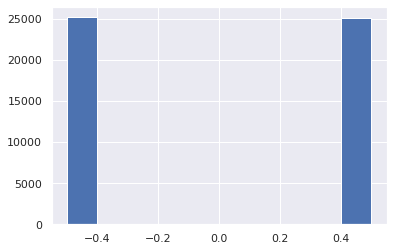

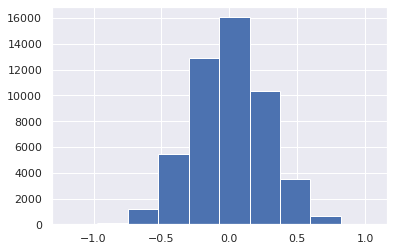

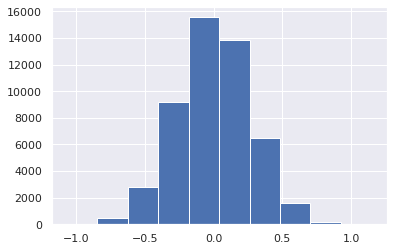

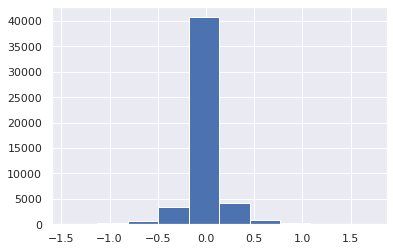

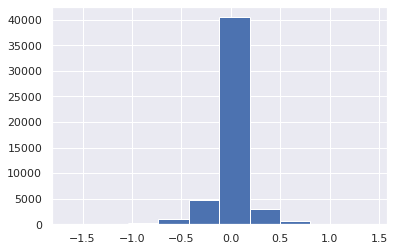

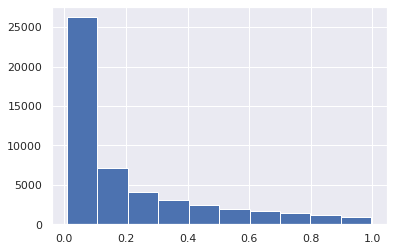

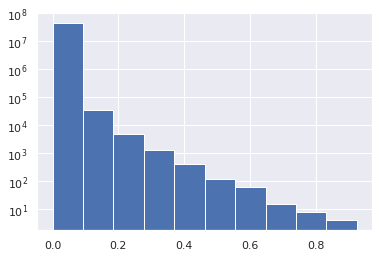

In [15]:
# plt.hist(ParticlePDG)
# plt.show()
# plt.hist(ParticlePoint[:,0])
# plt.show()
# plt.hist(ParticlePoint[:,1])
# plt.show()
# plt.hist(ParticleMomentum[:,0])
# plt.show()
# plt.hist(ParticleMomentum[:,1])
# plt.show()
# plt.hist(ParticleMomentum[:,2])
# plt.show()
# plt.hist(EnergyDeposit.reshape(-1,1))
# plt.yscale('log')
# plt.show()

In [0]:
EnergyDeposit    = torch.tensor(EnergyDeposit).float()
# EnergyDeposit = EnergyDeposit/EnergyDepositScale
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint    = torch.tensor(ParticlePoint).float()
ParticlePDG      = torch.tensor(ParticlePDG).float()

## Load it to pytorch `DataLoader`

In [0]:


# validation_split = 0.05
random_seed= 42
split = params["val_size"]
indices = list(range(params["train_size"]+params["val_size"]))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

calo_dataset    = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint, ParticlePDG)

train_loader = torch.utils.data.DataLoader(calo_dataset, batch_size=params["batch_size"], 
                                           sampler=train_sampler, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(calo_dataset, batch_size=params["batch_size"],
                                                sampler=valid_sampler, pin_memory=True)


# calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [0]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in validation_loader:
    break

## Training GAN
###### ...is not a simple matter

It depends on architecture, loss, instance noise, augmentation and even luck(recommend to take a look https://arxiv.org/pdf/1801.04406.pdf)


In this notebook I have prepared some basic parts that you could use for your experiments.

#### Small hack that can speed-up training and improve generalization

In [0]:
# from bayes import NoiseLoss,PriorLoss

In [0]:
def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Defining discriminator

## Defining generator

In [0]:
# import Label2Image
# from generator import ModelGConvTranspose
# from discriminator import ModelD

In [0]:

from NetworkUtil import ResidualBlock,ReducedConv2,ReducedConv,Self_Attn,normal_init,init_weights
from CosineExp import CosineExpLR
from torch.nn.utils import spectral_norm
from Test_Image import Make_Sample

In [0]:
# class Generator(nn.Module):
#     def __init__(self,dropout_gen=0., Ndim_cond=0):
#         super(Generator, self).__init__()
#         self.Ndim_cond = Ndim_cond
#         self.fc1 = nn.Linear(NOISEIMAGE_DIM**2+self.Ndim_cond,256)
#         self.fc2 = nn.Linear(self.fc1.out_features,self.fc1.out_features*2)
#         self.fc3 = nn.Linear(self.fc2.out_features,16*64)
#         # self.deconv0 = ReducedConv2(NOISEIMAGE_DIM**2+self.Ndim_cond,64,4,3)#(1,1)->(4,4)
#         # self.deconv0 = spectral_norm(nn.ConvTranspose2d(NOISEIMAGE_DIM**2+self.Ndim_cond,64,4))#(1,1)->(6,6)
#         self.deconv1 = ReducedConv2(64,32,2,3)#4->8
#         self.deconv2 = ReducedConv2(32,16,2,3)#8->16
#         self.deconv3 = ReducedConv2(16,1,2,5)#16->30
        
#         # self.deconv1 = spectral_norm(nn.ConvTranspose2d(64,32,4,stride=3))#(6,6)->(12,12)
#         # self.deconv2 = spectral_norm(nn.ConvTranspose2d(32,16,4,stride=2))#(8,8)->(16,16)
#         # self.deconv3 = spectral_norm(nn.ConvTranspose2d(16,1,3))#(16,16)->(30,30)
#         # self.bn0=nn.BatchNorm2d(self.deconv0.out_channels)
#         self.bn1=nn.BatchNorm2d(self.deconv1.out_channels)
#         self.bn2=nn.BatchNorm2d(self.deconv2.out_channels)
#         self.ssconv2=nn.Conv2d(self.deconv2.out_channels,self.deconv2.out_channels,3,padding=1)
#         self.rb1 = ResidualBlock(self.deconv1.out_channels)
#         self.rb2 = ResidualBlock(self.deconv2.out_channels)
#         self.dropout = nn.Dropout(dropout_gen)
#         # self.activation  = nn.LeakyReLU(alpha)
#         self.activation  = nn.ReLU()

#     def forward(self,x,condition=None):
#         x = x.view(x.shape[0],-1)
#         if condition is not None and self.Ndim_cond>0:
#             # condition = (condition-MomentumPointPDGOffset)/MomentumPointPDGScale
#             x = torch.cat([x,condition],dim=1)
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.activation(self.fc3(x))
#         # x = x.view(x.shape[0],-1,1,1)
#         x = x.view(x.shape[0],64,4,4)
#         # x = self.activation(self.dropout(self.bn0(self.deconv0(x))))
#         x = self.activation(self.dropout(self.bn1(self.deconv1(x))))
#         # for i in range(5):
#         #     x = self.rb1(x)
#         x = self.activation(self.dropout(self.bn2(self.deconv2(x))))
#         # x = self.deconv2(x)
#         # for i in range(5):
#         #     x = self.activation(self.dropout(self.bn2(self.ssconv2(x))))
#         x = self.deconv3(x)
#         return torch.tanh(x)
#         # return x
#         # return torch.max(x, torch.zeros(x.size()).to(device))
#         # return torch.sigmoid(x)

#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)

In [0]:
class Generator(nn.Module):
    def __init__(self,dropout_gen=0., Ndim_cond=0):
        super(Generator, self).__init__()
        self.Ndim_cond = Ndim_cond
        self.fc1 = nn.Linear(NOISEIMAGE_DIM**2+self.Ndim_cond,256)
        self.fc2 = nn.Linear(self.fc1.out_features,self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features,16*64)
        # self.deconv0 = ReducedConv2(NOISEIMAGE_DIM**2+self.Ndim_cond,64,4,3)#(1,1)->(4,4)
        # self.deconv0 = spectral_norm(nn.ConvTranspose2d(NOISEIMAGE_DIM**2+self.Ndim_cond,64,4))#(1,1)->(6,6)
        self.deconv1 = ReducedConv2(64,32,2,3)#4->8
        self.deconv2 = ReducedConv2(32,16,2,3)#8->16
        self.deconv3 = ReducedConv2(16,1,2,5)#16->30
        
        # self.deconv1 = spectral_norm(nn.ConvTranspose2d(64,32,4,stride=3))#(6,6)->(12,12)
        # self.deconv2 = spectral_norm(nn.ConvTranspose2d(32,16,4,stride=2))#(8,8)->(16,16)
        # self.deconv3 = spectral_norm(nn.ConvTranspose2d(16,1,3))#(16,16)->(30,30)
        # self.bn0=nn.BatchNorm2d(self.deconv0.out_channels)
        self.bn1=nn.BatchNorm2d(self.deconv1.out_channels)
        self.bn2=nn.BatchNorm2d(self.deconv2.out_channels)
        self.ssconv2=nn.Conv2d(self.deconv2.out_channels,self.deconv2.out_channels,3,padding=1)
        self.rb1 = ResidualBlock(self.deconv1.out_channels)
        self.rb2 = ResidualBlock(self.deconv2.out_channels)
        self.dropout = nn.Dropout(dropout_gen)
        # self.activation  = nn.LeakyReLU(alpha)
        self.activation  = nn.ReLU()

    def forward(self,x,condition=None):
        x = x.view(x.shape[0],-1)
        if condition is not None and self.Ndim_cond>0:
            # condition = (condition-MomentumPointPDGOffset)/MomentumPointPDGScale
            x = torch.cat([x,condition],dim=1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = x.view(x.shape[0],64,4,4)
        x = self.activation(self.dropout(self.bn1(self.deconv1(x))))
        x = self.activation(self.dropout(self.bn2(self.deconv2(x))))
        x = self.deconv3(x)
        return torch.tanh(x)
        # return x
        # return torch.max(x, torch.zeros(x.size()).to(device))
        # return torch.sigmoid(x)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [0]:
# class Discriminator(nn.Module):
#     def __init__(self,dropout_conv=0.0, Ndim_cond=0,aux=False,alpha=0.):
#         super(Discriminator, self).__init__()
#         # self.rconv1 = ReducedConv(1,Nlayer,)
#         self.Ndim_cond = Ndim_cond
#         self.conv1 = nn.Conv2d(1,16,kernel_size=2,padding=1,stride=2)#30->16
#         self.conv2 = nn.Conv2d(self.conv1.out_channels, self.conv1.out_channels*2, kernel_size=2,stride=2)#16->8
#         self.conv3 = nn.Conv2d(self.conv2.out_channels, self.conv2.out_channels*2, kernel_size=2,stride=2)#8->4
#         # self.conv4 = nn.Conv2d(self.conv3.out_channels, 1, kernel_size=4)#8->4
#         self.conv1 = spectral_norm(self.conv1)
#         self.conv2 = spectral_norm(self.conv2)
#         self.conv3 = spectral_norm(self.conv3)
#         self.rb1 = ResidualBlock(self.conv1.out_channels,False,True)
#         self.rb2 = ResidualBlock(self.conv2.out_channels,False,True)
#         self.ssconv1 = nn.Conv2d(self.conv1.out_channels, self.conv1.out_channels, kernel_size=3,padding = 1)#16->8
#         self.ssconv2 = nn.Conv2d(self.conv2.out_channels, self.conv2.out_channels, kernel_size=3,padding = 1)#16->8
#         self.ssconv1 = spectral_norm(self.ssconv1)
#         self.ssconv2 = spectral_norm(self.ssconv2)
#         self.fcstart = spectral_norm(nn.Linear(self.conv3.out_channels*16+self.Ndim_cond,256))
#         self.fcmid   = spectral_norm(nn.Linear(self.fcstart.out_features,self.fcstart.out_features//2))
#         self.fcend   = spectral_norm(nn.Linear(self.fcmid.out_features,1))
#         self.fcaux   = nn.Linear(self.fcmid.out_features,self.Ndim_cond)
#         if self.Ndim_cond>0:
#             self.fcaux = spectral_norm(self.fcaux)
        

#         self.dropout1 = nn.Dropout(dropout_conv)
#         self.activation  = nn.LeakyReLU(alpha)
#         self.attn1 = Self_Attn(self.conv1.out_channels, 'relu')
#         self.attn2 = Self_Attn(self.conv2.out_channels, 'relu')
#         # self.dropoutfc = nn.Dropout(dropout_fc)
#         # self.Nresblock = Nresblock
#         # self.Nsd = Nsd
        
#     def forward(self, x,condition=None):
#         # x_mppc = x/EnergyDepositScale
#         x_mppc = x.view(x.shape[0],1,30,30)
#         x_mppc = self.activation(self.conv1(x_mppc))
#         # for i in range(5):
#         #     x_mppc = self.rb1(x_mppc)
#         x_mppc, amap_1 = self.attn1(x_mppc)
#         x_mppc = self.activation(self.dropout1(self.conv2(x_mppc)))
#         x_mppc, amap_2 = self.attn2(x_mppc)
#         x_mppc = self.activation(self.dropout1(self.conv3(x_mppc)))
#         x = x_mppc.view(x_mppc.shape[0],-1)
#         if condition is not None:
#             # condition = (condition-MomentumPointPDGOffset)/MomentumPointPDGScale
#             x = torch.cat([x,condition],dim=1)
#         x = self.activation(self.fcstart(x))
#         x = self.activation(self.fcmid(x))
#         x_out = self.fcend(x)
#         x_aux = self.fcaux(x)
#         return x_out,x_aux
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)
            

In [0]:
class Discriminator(nn.Module):
    def __init__(self,dropout_conv=0.0, Ndim_cond=0,aux=False,alpha=0.):
        super(Discriminator, self).__init__()
        # self.rconv1 = ReducedConv(1,Nlayer,)
        self.Ndim_cond = Ndim_cond
        self.conv1 = nn.Conv2d(1,16,kernel_size=2,padding=1,stride=2)#30->16
        self.conv2 = nn.Conv2d(self.conv1.out_channels, self.conv1.out_channels*2, kernel_size=2,stride=2)#16->8
        self.conv3 = nn.Conv2d(self.conv2.out_channels, self.conv2.out_channels*2, kernel_size=2,stride=2)#8->4
        # self.conv4 = nn.Conv2d(self.conv3.out_channels, 1, kernel_size=4)#8->4
        # self.conv1 = spectral_norm(self.conv1)
        # self.conv2 = spectral_norm(self.conv2)
        # self.conv3 = spectral_norm(self.conv3)
        self.rb1 = ResidualBlock(self.conv1.out_channels,False,True)
        self.rb2 = ResidualBlock(self.conv2.out_channels,False,True)
        self.ssconv1 = nn.Conv2d(self.conv1.out_channels, self.conv1.out_channels, kernel_size=3,padding = 1)#16->8
        self.ssconv2 = nn.Conv2d(self.conv2.out_channels, self.conv2.out_channels, kernel_size=3,padding = 1)#16->8
        self.ssconv1 = spectral_norm(self.ssconv1)
        self.ssconv2 = spectral_norm(self.ssconv2)
        self.fcstart = nn.Linear(self.conv3.out_channels*16+self.Ndim_cond,256)
        self.fcmid   = nn.Linear(self.fcstart.out_features,self.fcstart.out_features//2)
        self.fcend   = nn.Linear(self.fcmid.out_features,1)
        self.fcaux   = nn.Linear(self.fcmid.out_features,self.Ndim_cond)
        # if self.Ndim_cond>0:
        #     self.fcaux = spectral_norm(self.fcaux)
        

        self.dropout1 = nn.Dropout(dropout_conv)
        self.activation  = nn.LeakyReLU(alpha)
        self.attn1 = Self_Attn(self.conv1.out_channels, 'relu')
        self.attn2 = Self_Attn(self.conv2.out_channels, 'relu')
        # self.dropoutfc = nn.Dropout(dropout_fc)
        # self.Nresblock = Nresblock
        # self.Nsd = Nsd
        
    def forward(self, x,condition=None):
        # x_mppc = x/EnergyDepositScale
        x_mppc = x.view(x.shape[0],1,30,30)
        x_mppc = self.activation(self.conv1(x_mppc))
        x_mppc = self.activation(self.dropout1(self.conv2(x_mppc)))
        x_mppc = self.activation(self.dropout1(self.conv3(x_mppc)))
        x = x_mppc.view(x_mppc.shape[0],-1)
        if condition is not None:
            x = torch.cat([x,condition],dim=1)
        x = self.activation(self.fcstart(x))
        x = self.activation(self.fcmid(x))
        x_out = self.fcend(x)
        x_aux = self.fcaux(x)
        return x_out,x_aux
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

## Check our models on one batch 

In [29]:

gens = []
discs = []
if params["conditional"]:
    gen  = Generator(params["dropout_gen"],params["Ncond_dim"]).to(device)
    disc = Discriminator(params["dropout_disc"],params["Ncond_dim"],params["AUX"],params["alpha"]).to(device)
else:
    gen  = Generator(params["dropout_gen"],0).to(device)
    disc = Discriminator(params["dropout_disc"],0,params["AUX"],params["alpha"]).to(device)

gen.apply(init_weights)
disc.apply(init_weights)
# gen.weight_init(mean=0.0, std=0.02)
# disc.weight_init(mean=0.0, std=0.02)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (rb1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.0)
  )
  (rb2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ac

In [0]:
# def LoadModels(epoch):
#     gen.load_state_dict(torch.load(GetGenPath(epoch)))
#     disc.load_state_dict(torch.load(GetDiscPath(epoch)))

In [0]:
# if restartfrom>0:
#     LoadModels(restartfrom)

In [0]:
EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b = EnergyDeposit_b.to(device), \
                                                       ParticleMomentum_b.to(device), \
                                                       ParticlePoint_b.to(device),\
                                                       ParticlePDG_b.to(device)
# print(ParticlePoint_b.shape,ParticlePDG_b.shape,)
# ParticlePDG_b= ParticlePDG_b.view(-1,1)
ParticleMomentum_ParticlePoint_ParticlePDG_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device),ParticlePDG_b.to(device)], dim=1)
ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

In [0]:
# disc(EnergyDeposit_b, ParticleMomentum_ParticlePoint_ParticlePDG_b)

In [0]:
noise = torch.randn(len(EnergyDeposit_b), NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
# gen(noise, ParticleMomentum_ParticlePoint_ParticlePDG_b).shape
# gen(noise, ParticleMomentum_ParticlePoint_b).shape

In [0]:
criterion = torch.nn.L1Loss().to(device)
# reg_loss = torch.nn.SmoothL1Loss().to(device)
# criterion = nn.BCELoss()
# gprior_criterion = PriorLoss(prior_std=1., observed=N)
# gnoise_criterion = NoiseLoss(params=gen.parameters(), noise_std=math.sqrt(2 * gnoise_alpha * learning_rate), observed=N)
# dprior_criterion = PriorLoss(prior_std=1., observed=N)
# dnoise_criterion = NoiseLoss(params=disc.parameters(), noise_std=math.sqrt(2 * dnoise_alpha * learning_rate), observed=N)

In [0]:
def calc_gradient_penalty(discriminator, data_gen, Condition_b, inp_data, lambda_reg = 10):
    alpha = torch.rand(inp_data.shape[0], 1).to(device)
    dims_to_add = len(inp_data.size()) - 2
    for i in range(dims_to_add):
        alpha = alpha.unsqueeze(-1)
    # alpha = alpha.expand(inp_data.size())

    interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(device)

    interpolates.requires_grad = True

    disc_interpolates,_ = discriminator(interpolates, Condition_b)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
    return gradient_penalty

## Defining optimiser

In [0]:
if params["optim"] == "Adam":
    gen_opt  = optim.Adam(gen.parameters() , lr=params["learning_rate"], betas=(0.9, 0.999), weight_decay=params["weight_decay"])
    disc_opt = optim.Adam(disc.parameters(), lr=params["learning_rate"]*params["lrratio"], betas=(0.9, 0.999), weight_decay=params["weight_decay"])
    
elif params["optim"] == "RMSProp":
    gen_opt  = optim.RMSprop(gen.parameters(), lr=params["learning_rate"])
    disc_opt = optim.RMSprop(disc.parameters(), lr=params["learning_rate"]*params["lrratio"])
    
# elif optimizer == "RMSAdam":
#     gen_opt  = optim.Adam(gen.parameters() , lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)
#     disc_opt = optim.RMSprop(disc.parameters(), lr=learning_rate)    
#     reg_gen_opt = optim.Adam(gen.parameters(), lr=learning_rate_reg, betas=(0.9,0.999))
#     reg_disc_opt = optim.RMSprop(disc.parameters(), lr=learning_rate_reg)
    


In [0]:
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
if params["LRtype"]=="Cyclic":
    scheduler_gen = CyclicLR(gen_opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
    scheduler_disc = CyclicLR(disc_opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler_gen = MultiStepLR(gen_opt, milestones=params["milestones"], gamma=params["LRgamma"])
    scheduler_disc = MultiStepLR(disc_opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler_gen = StepLR(gen_opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
    scheduler_disc = StepLR(disc_opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler_gen = CosineAnnealingLR(gen_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
    scheduler_disc = CosineAnnealingLR(disc_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
elif params["LRtype"]=="CosExp":
    scheduler_gen = CosineExpLR(gen_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])
    scheduler_disc = CosineExpLR(disc_opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

## Load scores

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

In [40]:
from Regressor import Regressor, load_embedder
embedder = load_embedder('./embedder.tp')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [0]:
def D_train(PMResponse_b,ibatch,Condition_b=None,gen_input=None):
    #=======================Train the discriminator=======================#
    disc_loss = 0
    disc_real = 0
    disc_fake = 0
    
    # disc_real = raw_real.mean()
    if gen_input is not None:
        PMResponse_gen = gen_input
    else:
        noise = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
        PMResponse_gen = gen(noise,Condition_b).to(device)
    
    PMResponse_b   = add_instance_noise(PMResponse_b,params["noiselevel"])
    PMResponse_gen = add_instance_noise(PMResponse_gen,params["noiselevel"])
    if params["AUX"]:
        raw_real,raw_aux_real = disc(PMResponse_b)
        raw_fake,raw_aux_fake = disc(PMResponse_gen)
    else:
        raw_real,raw_aux_real = disc(PMResponse_b,Condition_b)
        raw_fake,raw_aux_fake = disc(PMResponse_gen,Condition_b)
    if params["task"]=="HINGE":
        # disc_real = -torch.min(raw_real - 1, torch.zeros(raw_real.shape[0]).to(device)).mean()
        # disc_fake = -torch.min(-raw_fake - 1, torch.zeros(raw_fake.shape[0]).to(device)).mean()
        disc_real = nn.ReLU()(1.0 - raw_real).mean()
        disc_fake = nn.ReLU()(1.0 + raw_fake).mean()
        disc_loss = disc_real+disc_fake
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
        experiment.log_metric("d_raw_real", raw_real.mean().data.item(),step=ibatch)
        experiment.log_metric("d_raw_fake", raw_fake.mean().data.item(),step=ibatch)
    elif params["task"]=="NORMAL":
        eps=1e-10
        disc_real = F.logsigmoid(raw_real+eps).mean()
        disc_fake = F.logsigmoid(1-raw_fake+eps).mean()
        disc_loss = -disc_real-disc_fake
        # print(disc_loss,disc_real,disc_fake)
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
    elif params["task"]=="WASSERSTEIN":
        disc_real = raw_real.mean()
        disc_fake = raw_fake.mean()
        disc_loss = disc_fake - disc_real
        experiment.log_metric("d_real", disc_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake", disc_fake.data.item(),step=ibatch)
    # print(disc_loss,disc_real,disc_fake)
    
    if params["AUX"]:
        disc_aux_real = criterion(raw_aux_real,Condition_b)
        disc_aux_fake = criterion(raw_aux_fake,Condition_b)
        disc_aux = disc_aux_real + disc_aux_fake
        experiment.log_metric("d_real_aux", disc_aux_real.data.item(),step=ibatch)
        experiment.log_metric("d_fake_aux", disc_aux_fake.data.item(),step=ibatch)
        experiment.log_metric("d_aux", disc_aux.data.item(),step=ibatch)
        disc_loss += disc_aux
    if params["gp"]:
        grad_penalty = calc_gradient_penalty(disc,
                                            PMResponse_gen.data,
                                            Condition_b,
                                            PMResponse_b.data)
        disc_loss += grad_penalty    
        experiment.log_metric("grad_penalty", grad_penalty.data.item(),step=ibatch)
    # return
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    # print(disc_loss.data.item())
    
    experiment.log_metric("d_loss", disc_loss.data.item(),step=ibatch)
        
    return

In [0]:
def G_train(PMResponse_b,ibatch,Condition_b=None):
    #=======================Train the generator=======================#
    
    gen_loss = 0
    gen_real = 0
    gen_prior = 0
    gen_noise = 0
    noise = torch.randn(PMResponse_b.shape[0], NOISEIMAGE_DIM,NOISEIMAGE_DIM).to(device)
    PMResponse_gen = gen(noise,Condition_b)
    PMResponse_gen = add_instance_noise(PMResponse_gen,params["noiselevel"])
    if params["AUX"]:
        raw_gen,raw_gen_aux = disc(PMResponse_gen)
    else:
        raw_gen,raw_gen_aux = disc(PMResponse_gen,Condition_b)
    if params["task"]=="HINGE" or params["task"]=="WASSERSTEIN":
        gen_real = raw_gen.mean()
        gen_loss = -gen_real
        experiment.log_metric("g_real_loss", gen_real.data.item(),step=ibatch)
    elif params["task"]=="NORMAL":
        eps=1e-10
        logp_gen_is_real = F.logsigmoid(raw_gen+eps).mean()
        gen_loss = -logp_gen_is_real

    if params["AUX"]:
        disc_fake_aux = criterion(raw_gen_aux,Condition_b)
        experiment.log_metric("g_fake_aux", disc_fake_aux.data.item(),step=ibatch)
        gen_loss += disc_fake_aux
    experiment.log_metric("g_loss", gen_loss.data.item(),step=ibatch)
    
    gen_opt.zero_grad()         
    gen_loss.backward()
    gen_opt.step()
    # disc.load(disc_back)
    return PMResponse_gen
    # gen_opt.zero_grad()
    

In [0]:
def CalculatePRDScore():
    batch = 0
    plt.figure(figsize=(15,12))
    prd_aucs = []
    for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in validation_loader:
        noise = torch.randn(len(EnergyDeposit_b), NOISEIMAGE_DIM, NOISEIMAGE_DIM).to(device)
        ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
        ParticleMomentum_ParticlePoint_ParticlePDG_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device),ParticlePDG_b.to(device)], dim=1)
        if params["Ncond_dim"]==6:
            EnergyDeposit_gen = gen(noise, ParticleMomentum_ParticlePoint_ParticlePDG_b)
        elif params["Ncond_dim"]==5:
            EnergyDeposit_gen = gen(noise, ParticleMomentum_ParticlePoint_b)
        elif params["Ncond_dim"]==2:
            EnergyDeposit_gen = gen(noise, ParticlePoint_b.to(device))
        else:
            EnergyDeposit_gen = gen(noise)

        data_real = embedder.get_encoding(torch.tensor(EnergyDeposit_b).float().view(-1, 1, 30, 30)).detach().numpy()
        data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen.cpu()).float().view(-1, 1, 30, 30)).detach().numpy()
        precision, recall = compute_prd_from_embedding(data_real, data_fake,num_clusters=20,num_runs=10)
        # precisions, recalls = calc_pr_rec(data_real,data_fake)
        prd_auc_ = auc(precision, recall)
        prd_aucs.append(prd_auc_)
        plt.step(recall, precision, color='r', alpha=1,  label='PR')
        # if prd_auc_>0:
            
        # break
        # if batch>3:
        #     experiment.log_figure(figure=plt)
        #     break
        # else:
        #     batch+=1
    np_prd_aucs = np.array(prd_aucs)
    prd_auc_ = np.mean(np_prd_aucs)
    # experiment.log_figure(figure=plt)
    return prd_auc_

In [0]:
# def SaveModels(disc,gen,epoch):
    
#     # gen  = ModelGConvTranspose_SMALL(z_dim=NOISEIMAGE_DIM, MomentumPointPDGScale = MomentumPointPDGScale.to(device),EnergyScale = EnergyDepositScale.to(device), Nredconv_gen=Nredconv_gen).to(device)
#     use_bn = True
#     if TASK=='WASSERSTEIN' or TASK=='CRAMER':
#         use_bn = False
        
#     disc_cpu = ModelD(
#         cond_dim=6, 
#         MomentumPointPDGScale=MomentumPointPDGScale.to(device), 
#         MomentumPointPDGOffset=MomentumPointPDGOffset.to(device), 
#         EnergyScale = EnergyDepositScale.to(device),
#         EnergyOffset = EnergyDepositOffset.to(device),
#         Nredconv_dis=Nresblock,
#         dropout_fraction=dropout_disc,
#         use_bn=use_bn,
#         use_additionalinfo = use_additionalinfo
#         )
    
#     disc_cpu.load_state_dict(disc.state_dict())
#     # generator_cpu.eval()
#     torch.save(disc_cpu.state_dict(), GetDiscPath(epoch))
#     gen_cpu  = ModelGConvTranspose(
#         z_dim=NOISEIMAGE_DIM, 
#         MomentumPointPDGScale = MomentumPointPDGScale.to(device),
#         MomentumPointPDGOffset=MomentumPointPDGOffset.to(device), 
#         EnergyScale = EnergyDepositScale.to(device), 
#         EnergyOffset = EnergyDepositOffset.to(device),
#         Nredconv_gen=Nredconv_gen,
#         add_dense = add_dense,
#         use_resblock =use_resblock
#     )
#     gen_cpu.load_state_dict(gen.state_dict())
#     # generator_cpu.eval()
#     torch.save(gen_cpu.state_dict(), GetGenPath(epoch))
#     return

In [0]:
def Training(EnergyDeposit_b,ibatch,Condition_b=None):
    for itrain in range(params["ntrain_d"]):
            D_train(EnergyDeposit_b,ibatch, Condition_b)
    EnergyDeposit_gen = G_train(EnergyDeposit_b,ibatch, Condition_b)
    return EnergyDeposit_gen


In [0]:
LIPSITZ_WEIGHTS = False
# ntrain_d = 1
def run_training(epochs):
    ibatch = 0
    dis_epoch_loss = []
    gen_epoch_loss = []
    predictions_dis = []
    predictions_gen = []
    TotalEnergyDeposit_dis = []
    TotalEnergyDeposit_gen = []    
    prd_auc = []  
    for epoch in tqdm(range(restartfrom,epochs)):
        first = True
        experiment.log_metric("learning_rate", scheduler_gen.get_lr(),step=epoch)
        if params["test_sample"]:
            for i in range(int(params["train_size"]/params["batch_size"])):
                EnergyDeposit_b = Make_Sample(params["batch_size"],30,30).to(device)
                EnergyDeposit_gen = Training(EnergyDeposit_b,ibatch)
                ibatch += 1
        else:
            for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in train_loader:
                EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b = EnergyDeposit_b.to(device), \
                                                                    ParticleMomentum_b.to(device), \
                                                                    ParticlePoint_b.to(device),\
                                                                    ParticlePDG_b.view(-1,1).to(device)

                # ParticlePoint_b = ParticlePoint_b.to(device)], dim=1)
                ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
                ParticleMomentum_ParticlePoint_ParticlePDG_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device), ParticlePDG_b.to(device)], dim=1)
                
                if params["conditional"]:
                    if params["Ncond_dim"]==6:
                        Condition_b = ParticleMomentum_ParticlePoint_ParticlePDG_b
                    elif params["Ncond_dim"]==5:
                        Condition_b = ParticleMomentum_ParticlePoint_b
                    elif params["Ncond_dim"]==2:
                        Condition_b = ParticlePoint_b
                else:
                    Condition_b = None
                EnergyDeposit_gen = Training(EnergyDeposit_b,ibatch,Condition_b)
                ibatch += 1
            # for itrain in range(params["ntrain_d"]):
            #     D_train(EnergyDeposit_b,ibatch, Condition_b)
            # EnergyDeposit_gen = G_train(EnergyDeposit_b,ibatch, Condition_b)
            # if LIPSITZ_WEIGHTS:                    
            #     [p.data.clamp_(-0.01, 0.01) for p in disc.parameters()]
            
            # if first:
            # if ibatch %300 ==1:
        if not params["test_sample"]:
            prd_auc_ = CalculatePRDScore()
            prd_auc.append(prd_auc_)
            experiment.log_metric("PRD_AUC", prd_auc_,step=epoch)
        # SaveModels(disc,gen,epoch)
        # first=False
    
        clear_output()
    # if ibatch %50 ==2:
        plt.figure(figsize=(15,12))
        grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
        for event in range(3):
            plt.subplot(grid[0,event])
            plt.imshow(EnergyDeposit_b[event][0].cpu().detach().numpy(),vmin=0,origin='lower')
            plt.colorbar()
            # plt.title("Momentum: (%f,%f,%f) \n Position: (%f,%f)"%(
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][0],
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][1],
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][2],
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][3],
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][4]
            #     )
            # )
            # plt.title("True: %f, Rec: %f"%(
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][0],
            #     ParticleMomentum_ParticlePoint_ParticlePDG_b[event][0],
            #     )
            # )
            plt.subplot(grid[1, event])
            plt.imshow(EnergyDeposit_gen[event][0].cpu().detach().numpy(),vmin=0,origin='lower')
            plt.colorbar()
                
        experiment.log_figure(figure_name="status%d"%(epoch),figure=plt,step =epoch)
        # time.sleep(0.5)
        plt.close()
#             plt.show()
        # ibatch += 1
        scheduler_gen.step()
        scheduler_disc.step()



In [0]:
with experiment.train():
    run_training(params["Nepoch"])

#### Transfer generator on CPU:

In [0]:
generator_cpu = ModelGConvTranspose(z_dim=NOISEIMAGE_DIM,MomentumPointPDGScale = MomentumPointPDGScale,EnergyScale = EnergyDepositScale)
# generator_cpu.load_state_dict(gen.state_dict())
generator_cpu.load_state_dict(torch.load('/gdrive/My Drive/gan80.pt'))
# generator_cpu.eval()

### Save model on disk

In [0]:
torch.save(generator_cpu.state_dict(), './gan_middle.pt')

## Making predictions

#### Validation predictions

In [0]:
data_val = np.load(val_data_path, allow_pickle=True)
ParticleMomentum_val = torch.tensor(data_val['ParticleMomentum']).float()
ParticlePoint_val = torch.tensor(data_val['ParticlePoint'][:, :2]).float()
ParticlePDG_val = torch.tensor(data_val['ParticlePDG'].reshape(-1,1)).float()
ParticleMomentum_ParticlePoint_ParticlePDG_val = torch.cat([ParticleMomentum_val, ParticlePoint_val,ParticlePDG_val], dim=1)
calo_dataset_val = utils.TensorDataset(ParticleMomentum_ParticlePoint_ParticlePDG_val)
calo_dataloader_val = torch.utils.data.DataLoader(calo_dataset_val, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_val = []
    for ParticleMomentum_ParticlePoint_ParticlePDG_val_batch in tqdm(calo_dataloader_val):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_ParticlePDG_val_batch[0]), NOISEIMAGE_DIM,NOISEIMAGE_DIM)
        EnergyDeposit_val_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG_val_batch[0]).detach().numpy()
        EnergyDeposit_val.append(EnergyDeposit_val_batch)
    np.savez_compressed('./data_val_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_val
del data_val; del ParticleMomentum_val; del ParticlePoint_val; del ParticleMomentum_ParticlePoint_ParticlePDG_val;
del calo_dataset_val; calo_dataloader_val

#### Test predictions

In [0]:
data_test = np.load(test_data_path, allow_pickle=True)
ParticleMomentum_test = torch.tensor(data_test['ParticleMomentum']).float()
ParticlePoint_test = torch.tensor(data_test['ParticlePoint'][:, :2]).float()
ParticlePDG_test = torch.tensor(data_test['ParticlePDG'].reshape(-1,1)).float()
ParticleMomentum_ParticlePoint_ParticlePDG_test = torch.cat([ParticleMomentum_test, ParticlePoint_test, ParticlePDG_test], dim=1)
calo_dataset_test = utils.TensorDataset(ParticleMomentum_ParticlePoint_ParticlePDG_test)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_test = []
    for ParticleMomentum_ParticlePoint_ParticlePDG_test_batch in tqdm(calo_dataloader_test):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_ParticlePDG_test_batch[0]), NOISE_DIM)
        EnergyDeposit_test_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG_test_batch[0]).detach().numpy()
        EnergyDeposit_test.append(EnergyDeposit_test_batch)
    np.savez_compressed('./data_test_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_test, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_test
del data_test; del ParticleMomentum_test; del ParticlePoint_test; del ParticleMomentum_ParticlePoint_ParticlePDG_test;
del calo_dataset_test; calo_dataloader_test

## `zip-zip` files together

In [0]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

In [0]:
from IPython.display import FileLink
FileLink('./solution.zip')

# A few words about metrics

### Lets generate some fake data

In [0]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in validation_loader:
    break

In [0]:
noise = torch.randn(len(ParticleMomentum_b), NOISE_DIM)
with torch.no_grad():
    ParticleMomentum_ParticlePoint_ParticlePDG = torch.cat([ParticleMomentum_b, 
                                                ParticlePoint_b,
                                                ParticlePDG_b], dim=1)
    EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint_ParticlePDG.cpu())

In [0]:
EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)
EnergyDeposit_b = EnergyDeposit_b.detach().cpu().numpy().reshape(-1, 30, 30)

#### Plot one image

In [0]:
plt.figure()
plt.imshow(EnergyDeposit_gen[2])
plt.colorbar()

## Calculate PRD score between these batch 

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256, 256) 
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 3)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x), self.fc5(x)
    
    def get_encoding(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def load_embedder(path):
    embedder = torch.load(path)
    embedder.eval()
    return embedder

embedder = load_embedder('./embedder.tp')

In [0]:
data_real = embedder.get_encoding(torch.tensor(EnergyDeposit_b).float().view(-1, 1, 30, 30)).detach().numpy()
data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen).float().view(-1, 1, 30, 30)).detach().numpy()

In [0]:
def plot_pr_aucs(precisions, recalls):
    plt.figure(figsize=(12, 12))
    pr_aucs = []
    for i in range(len(recalls)):
        plt.step(recalls[i], precisions[i], color='b', alpha=0.2,  label='PR-AUC={}'.format(auc(precisions[i], recalls[i])))
        pr_aucs.append(auc(precisions[i], recalls[i]))
    plt.step(np.mean(recalls, axis=0), np.mean(precisions, axis=0), color='r', alpha=1,  label='average')
    plt.fill_between(np.mean(recalls, axis=0), 
                     np.mean(precisions, axis=0) - np.std(precisions, axis=0) * 3,
                     np.mean(precisions, axis=0) + np.std(precisions, axis=0) * 3, color='g', alpha=0.2,  label='std')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    print(np.mean(pr_aucs), np.std(pr_aucs))
    plt.legend()
    
    return pr_aucs

def calc_pr_rec(data_real, data_fake, num_clusters=20, num_runs=10, NUM_RUNS=10):
    precisions = []
    recalls = []
    for i in tqdm(range(NUM_RUNS)):
        precision, recall = compute_prd_from_embedding(data_real, data_fake, num_clusters=num_clusters, num_runs=num_runs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [0]:
precisions, recalls = calc_pr_rec(data_real, data_fake, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs

## Physical metrics

In [0]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def plot_axes_for_shower(ecal, point, p):
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)

    xx, yy = np.meshgrid(x, y)
    zoff = 25.
    ipic = 3
    orth = np.array([-p[1], p[0]])

    pref = point[:2] + p[:2] * zoff / p[2]

    p1 = pref - 10 * p[:2]
    p2 = pref + 10 * p[:2]
    p3 = pref - 10 * orth
    p4 = pref + 10 * orth

    plt.contourf(xx, yy, np.log(ecal + 1), cmap=plt.cm.inferno)
    newline(p1, p2)
    newline(p3, p4)
    plt.colorbar()

In [0]:
idx = 2
plot_axes_for_shower(EnergyDeposit[idx], point=ParticlePoint[idx].detach().numpy(),
                     p=ParticleMomentum[idx].detach().numpy())

In [0]:
from calogan_metrics import get_assymetry, get_shower_width, get_sparsity_level

In [0]:
assym = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
assym_ortho = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sh_width = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
sh_width_ortho = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sparsity_level = get_sparsity_level(EnergyDeposit)

## Longitudual cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')

## Transverse cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym_ortho, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')

## Cluster longitudual width

In [0]:
plt.hist(sh_width, bins=50, range=[0, 15], normed=True, alpha=0.3, color='red', label='MC');
plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')

## Cluster trasverse width

In [0]:
plt.hist(sh_width_ortho, bins=50, range=[0,10], normed=True, alpha=0.3, color='blue', label='MC');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')

## Sparsity

In [0]:
alphas = np.log(np.logspace(-5, -1, 20))
means_r = np.mean(sparsity_level, axis=1)
stddev_r = np.std(sparsity_level, axis=1)

In [0]:
plt.plot(alphas, means_r, color='red')
plt.fill_between(alphas, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.legend(['MC'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')

In [0]:
from calogan_metrics import get_physical_stats
real_phys_stats = get_physical_stats(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())
gen_phys_stats = get_physical_stats(EnergyDeposit_gen, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())

In [0]:
precisions, recalls = calc_pr_rec(real_phys_stats, gen_phys_stats, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs